In [1]:
import dataclasses
import enum
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.tree._tree import Tree
from sklearn.model_selection import train_test_split

from typing import Optional


class Allocator(enum.Enum):
    IRC = "irc"
    LS = "ls"


ALLOCATOR_ENCODING = {
    Allocator.IRC: 0,
    Allocator.LS: 1,
}
ALLOCATOR_DECODING = {value: key for key, value in ALLOCATOR_ENCODING.items()}
ALLOCATOR_OCAML_NAME = {
    Allocator.IRC: "IRC",
    Allocator.LS: "LS",
}


@dataclasses.dataclass
class CSVData:
    function_names: pd.Series
    durations: dict[Allocator, list[pd.Series]]
    in_stats: pd.DataFrame
    out_stats: dict[Allocator, pd.DataFrame]

In [2]:
N = 7  # keep in sync with shell script


def load_csv_data() -> CSVData:
    function_names: Optional[pd.Series] = None
    durations: dict[Allocator, list[pd.Series]] = {
        allocator: [] for allocator in Allocator
    }
    in_stats: Optional[pd.DataFrame] = None
    out_stats: dict[Allocator, pd.DataFrame] = {}
    for allocator in Allocator:
        for n in range(1, N + 1):
            csv_file = f"learn_linscan_choice_{allocator.value}_{n}.csv"
            df = pd.read_csv(csv_file, sep=";")
            assert (
                df["allocator"] == allocator.value
            ).all(), f"expected only uses of {allocator.value}"
            if function_names is None:
                function_names = df["function_name"]
            else:
                assert (
                    function_names == df["function_name"]
                ).all(), "mismatch in processed functions"
            durations[allocator].append(df["duration"])
            if in_stats is None:
                in_columns = [
                    column for column in df.columns if column.startswith("in_")
                ]
                in_stats = df[in_columns]
            if allocator not in out_stats:
                out_columns = [
                    column for column in df.columns if column.startswith("out_")
                ]
                subst = {
                    column: f"{allocator.value}_{column}" for column in out_columns
                }
                out_stats[allocator] = df[out_columns].rename(columns=subst)
    assert function_names is not None, "no functions"
    assert in_stats is not None, "no 'in' stats"
    return CSVData(
        function_names=function_names,
        durations=durations,
        in_stats=in_stats,
        out_stats=out_stats,
    )


def mean(items: list[float]) -> float:
    assert len(items) > 0, "empty list"
    total = 0.0
    for item in items:
        total += item
    return total / len(items)


def build_dataframe(data: CSVData) -> pd.DataFrame:
    df = pd.DataFrame(data.in_stats)
    df.insert(loc=0, column="function_name", value=data.function_names)
    for allocator in Allocator:
        durations = []
        for row_idx in range(len(data.function_names)):
            all_durations = [
                data.durations[allocator][run_idx][row_idx] for run_idx in range(N)
            ]
            all_durations.remove(max(all_durations))
            durations.append(mean(all_durations))
        df.insert(
            loc=len(df.columns), column=f"{allocator.value}_duration", value=durations
        )
        df = pd.concat([df, data.out_stats[allocator]], axis=1)
    df["in_is_entry_function"] = df["in_is_entry_function"].astype(int)
    return df

In [3]:
# builds a dataframe with all in_stats, and per-allocator out_stats
df = build_dataframe(load_csv_data())

# remove some columns
IGNORED_COLUMNS = ["function_name", "in_num_high_pressure_points"]
for ignore_column in IGNORED_COLUMNS:
    df.drop(ignore_column, axis=1, inplace=True)

# split dataframe
train_data, test_data = train_test_split(df, test_size=0.2)
train_data

,in_is_entry_function,in_num_regs,in_num_blocks,in_num_instrs,in_num_destruction_points,irc_duration,irc_out_spills,irc_out_reloads,irc_out_spill_cost,irc_out_reload_cost,ls_duration,ls_out_spills,ls_out_reloads,ls_out_spill_cost,ls_out_reload_cost
51909,0,9,3,17,1,0.000047,1,1,1,1,0.000037,1,1,1,1
45634,0,15,10,37,1,0.000082,2,2,20,20,0.000070,2,2,20,20
45711,0,5,4,11,0,0.000029,0,0,0,0,0.000014,0,0,0,0
26643,0,16,4,32,2,0.000075,2,2,2,2,0.000066,2,2,2,2
14352,0,32,8,61,6,0.000137,7,7,7,7,0.000137,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,0,15,5,27,0,0.000068,0,0,0,0,0.000030,0,0,0,0
26096,0,31,8,53,0,0.000095,0,0,0,0,0.000050,0,0,0,0
47956,0,6,3,13,1,0.000038,0,0,0,0,0.000023,0,0,0,0
35459,0,7,5,17,1,0.000047,1,1,1,1,0.000039,1,1,1,1


In [4]:
def default_function(row) -> Allocator:
    # implementation of the default strategy
    # keep in sync with OCaml code
    use_linscan = row["in_is_entry_function"] == 1 or row["in_num_regs"] >= 100000
    return Allocator.LS if use_linscan else Allocator.IRC


LS_FACTOR = 0.90


def choice_function(row) -> Allocator:
    # "goal": we want to use ls when faster and not worse in terms of spills/reloads
    irc_duration = row["irc_duration"]
    irc_spills_reloads = row["irc_out_spills"] + row["irc_out_reloads"]
    ls_duration = row["ls_duration"]
    ls_spills_reloads = row["ls_out_spills"] + row["ls_out_reloads"]
    if (ls_duration <= LS_FACTOR * irc_duration) and (
        ls_spills_reloads <= irc_spills_reloads
    ):
        return Allocator.LS
    else:
        return Allocator.IRC


def compute_choices(df: pd.DataFrame) -> pd.Series:
    res = []
    for _index, row in df.iterrows():
        res.append(ALLOCATOR_ENCODING[choice_function(row)])
    return res


def extract_features(df: pd.DataFrame) -> pd.DataFrame:
    columns_to_keep = [column for column in df.columns if column.startswith("in_")]
    return df[columns_to_keep]

In [5]:
MAX_DEPTH = 5  # max depth of the generated tree

features = extract_features(train_data)
target = compute_choices(train_data)
classifier = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH).fit(features, target)

(array([<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'cost'}>], dtype=object),
 array([<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'cost'}>], dtype=object))

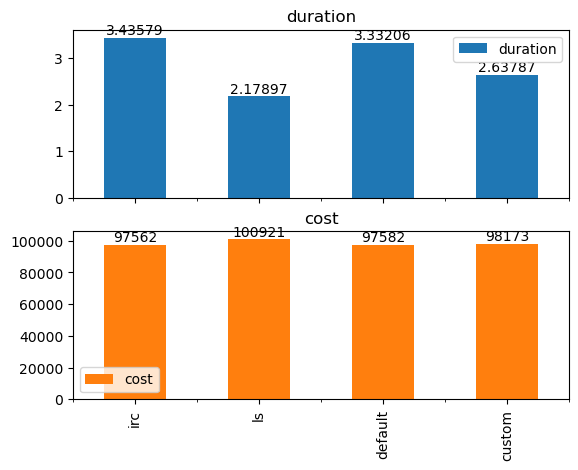

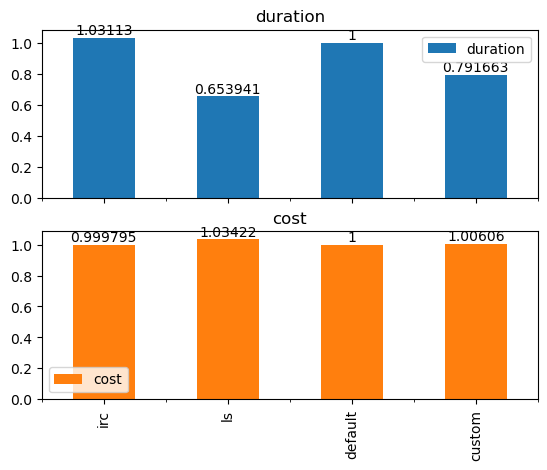

In [6]:
predicted = pd.Series(classifier.predict(extract_features(test_data)))


def apply_default_function(df: pd.DataFrame) -> pd.Series:
    res: list[int] = []
    for _index, row in df.iterrows():
        res.append(ALLOCATOR_ENCODING[default_function(row)])
    return pd.Series(res)


default = apply_default_function(extract_features(test_data))


def get_duration(row, allocator_as_int: int) -> float:
    allocator = ALLOCATOR_DECODING[allocator_as_int]
    return float(row[f"{allocator.value}_duration"])


def get_spills_reloads(row, allocator_as_int: int) -> int:
    allocator = ALLOCATOR_DECODING[allocator_as_int]
    return int(row[f"{allocator.value}_out_spills"]) + int(
        row[f"{allocator.value}_out_reloads"]
    )


def compare(
    test_data: pd.DataFrame, predicted: pd.Series, default: pd.Series
) -> pd.DataFrame:
    # CR xclerc for xclerc: refactor this function
    irc_duration = 0.0
    irc_cost = 0
    ls_duration = 0.0
    ls_cost = 0
    predicted_duration = 0.0
    predicted_cost = 0
    default_duration = 0.0
    default_cost = 0
    irc = ALLOCATOR_ENCODING[Allocator.IRC]
    ls = ALLOCATOR_ENCODING[Allocator.LS]
    for idx, (_, row) in enumerate(test_data.iterrows()):
        irc_duration += get_duration(row, irc)
        irc_cost += get_spills_reloads(row, irc)
        ls_duration += get_duration(row, ls)
        ls_cost += get_spills_reloads(row, ls)
        predicted_allocator = predicted[idx]
        default_allocator = default[idx]
        predicted_duration += get_duration(row, predicted_allocator)
        predicted_cost += get_spills_reloads(row, predicted_allocator)
        default_duration += get_duration(row, default_allocator)
        default_cost += get_spills_reloads(row, default_allocator)
    return pd.DataFrame(
        columns=["duration", "cost"],
        index=["irc", "ls", "default", "custom"],
        data=[
            [irc_duration, irc_cost],
            [ls_duration, ls_cost],
            [default_duration, default_cost],
            [predicted_duration, predicted_cost],
        ],
    ), pd.DataFrame(
        columns=["duration", "cost"],
        index=["irc", "ls", "default", "custom"],
        data=[
            [irc_duration / default_duration, irc_cost / default_cost],
            [ls_duration / default_duration, ls_cost / default_cost],
            [default_duration / default_duration, default_cost / default_cost],
            [predicted_duration / default_duration, predicted_cost / default_cost],
        ],
    )


def display_chart(df):
    chart = df.plot.bar(subplots=True)
    for sub in chart:
        for container in sub.containers:
            sub.bar_label(container)
    return chart


raw, normalized = compare(test_data, predicted, default)
display_chart(raw), display_chart(normalized)

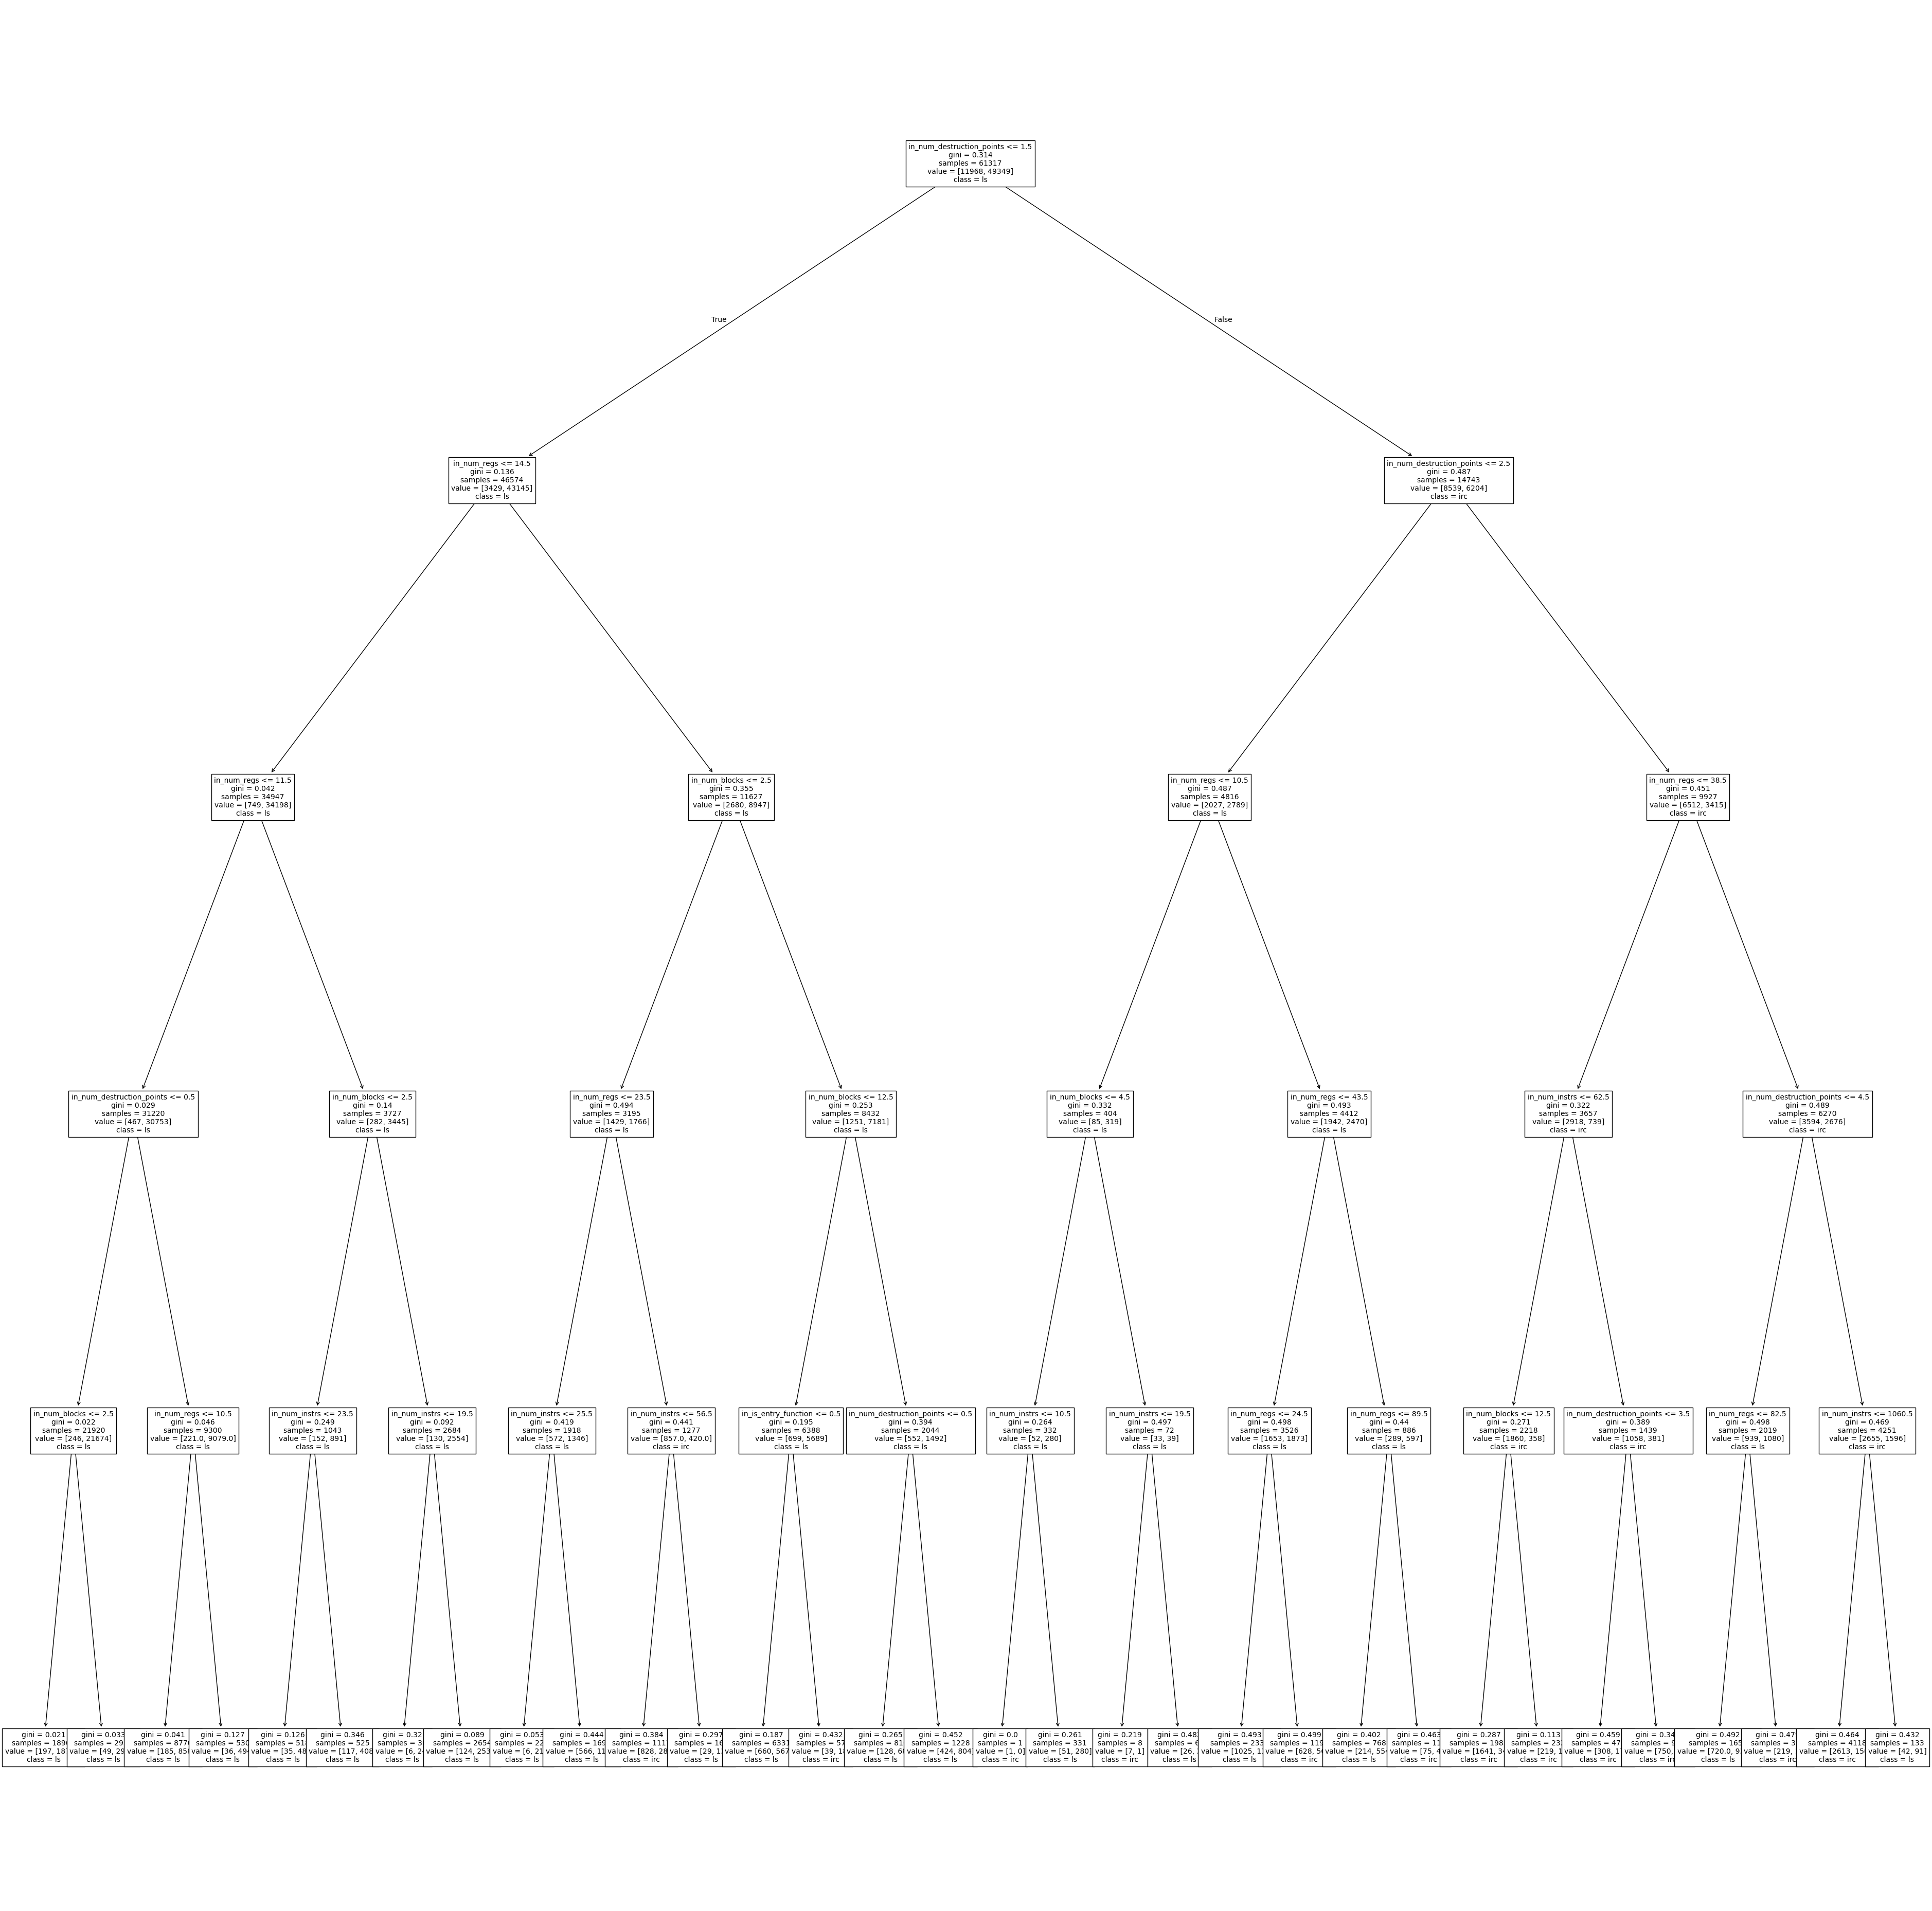

In [7]:
# display decision tree

plt.figure(figsize=(48, 48))
tree.plot_tree(
    classifier,
    fontsize=10,
    feature_names=features.columns,
    class_names=[ALLOCATOR_DECODING[i].value for i in range(len(Allocator))],
)
plt.show()

In [8]:
# (experimental) generate the OCaml function for the "custom" strategy


def compile_node(
    indent: int, tree: Tree, node_index: int, used_features: set[str]
) -> list[tuple[int, str]]:
    if tree.children_left[node_index] == -1:
        value = tree.value[node_index][0]
        assert len(value) == len(Allocator), f"{len(value)=} {value=}"
        allocator = ALLOCATOR_DECODING[0 if value[0] > value[1] else 1]
        return [(indent, f"{ALLOCATOR_OCAML_NAME[allocator]}")]
    else:
        feature_name = features.columns[tree.feature[node_index]]
        used_features.add(feature_name)
        threshold = tree.threshold[node_index]
        return (
            [(indent, f"if {feature_name} <= {threshold} then begin")]
            + compile_node(
                indent=indent + 1,
                tree=tree,
                node_index=tree.children_left[node_index],
                used_features=used_features,
            )
            + [(indent, "end else begin")]
            + compile_node(
                indent=indent + 1,
                tree=tree,
                node_index=tree.children_right[node_index],
                used_features=used_features,
            )
            + [(indent, "end")]
        )


def string_of_line(line: tuple[int, str]) -> str:
    indent, contents = line
    return ("  " * indent) + contents


FEATURE_EXPRESSIONS = {
    "in_is_entry_function": "if in_stats.is_entry_function then 1.0 else 0.0",
    "in_num_regs": "float(in_stats.num_regs)",
    "in_num_blocks": "float(in_stats.num_blocks)",
    "in_num_instrs": "float(in_stats.num_instrs)",
    "in_num_destruction_points": "float(in_stats.num_destruction_points)",
    "num_high_pressure_points": "float(in_stats.num_high_pressure_points)",
}


def print_function():
    print("let custom_strategy in_stats =")
    used_features: set[str] = set()
    lines = compile_node(
        indent=1, tree=classifier.tree_, node_index=0, used_features=used_features
    )
    for used_feature in used_features:
        print(f"  let {used_feature} = {FEATURE_EXPRESSIONS[used_feature]} in")
    print("\n".join(map(string_of_line, lines)))


print_function()

let custom_strategy in_stats =
  let in_num_blocks = float(in_stats.num_blocks) in
  let in_num_destruction_points = float(in_stats.num_destruction_points) in
  let in_num_regs = float(in_stats.num_regs) in
  let in_num_instrs = float(in_stats.num_instrs) in
  let in_is_entry_function = if in_stats.is_entry_function then 1.0 else 0.0 in
  if in_num_destruction_points <= 1.5 then begin
    if in_num_regs <= 14.5 then begin
      if in_num_regs <= 11.5 then begin
        if in_num_destruction_points <= 0.5 then begin
          if in_num_blocks <= 2.5 then begin
            LS
          end else begin
            LS
          end
        end else begin
          if in_num_regs <= 10.5 then begin
            LS
          end else begin
            LS
          end
        end
      end else begin
        if in_num_blocks <= 2.5 then begin
          if in_num_instrs <= 23.5 then begin
            LS
          end else begin
            LS
          end
        end else begin
          if in